In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import pandas as pd
import glob

from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            f1_score, precision_recall_curve, PrecisionRecallDisplay,\
                            roc_auc_score
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Sigmoid, Module, BCELoss, Linear
from torch.optim import Adam

import torchvision
from torchvision import transforms

from PIL import Image
import cv2
import onnxruntime
import onnx

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
class FaceDataset(Dataset):
    
    def __init__(self, image_metadata, labels, mode='valid'):
        self.image_metadata = image_metadata
        self.labels = labels
        self.mode = mode
#         self.random_transform = transforms.Compose([
# #             transforms.RandomErasing(p=0.5),
#             transforms.RandomHorizontalFlip(p=0.5)
#         ])
        self.nesessary_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
            
    def __len__(self):
        return self.labels.shape[0]
        
    def __getitem__(self, idx):
        image = Image.open(self.image_metadata[idx])
#         if self.mode=='train': 
#             image = self.random_transform(image)           
        prepared_tensor = self.nesessary_transform(image)
        return prepared_tensor, self.labels[idx]    


In [3]:
train_pos_path_list = [
    '/workspace/db/train/with_mask/afdb',
    '/workspace/db/train/with_mask/medsi',
    '/workspace/db/train/with_mask/py_image_search',
    '/workspace/db/train/with_mask/sibur',
]

train_neg_path_list = [
    '/workspace/db/train/wo_mask/afdb',
    '/workspace/db/train/wo_mask/hand',
    '/workspace/db/train/wo_mask/medsi',
    '/workspace/db/train/wo_mask/py_image_search',
    '/workspace/db/train/wo_mask/sibur/0',
]

valid_test_pos_path_list = [
    '/workspace/db/val/with_mask/afdb',
    '/workspace/db/val/with_mask/medsi',
    '/workspace/db/val/with_mask/py_image_search',
    '/workspace/db/val/with_mask/sibur',
]

valid_test_neg_path_list = [
    '/workspace/db/val/wo_mask/afdb',
    '/workspace/db/val/wo_mask/hand',
    '/workspace/db/val/wo_mask/medsi/0',
    '/workspace/db/val/wo_mask/py_image_search',
    '/workspace/db/val/wo_mask/sibur/0',
]

In [4]:
train_image_metadata = np.empty((0), dtype=str)
train_labels = np.empty((0), dtype=int)
for directory in train_pos_path_list:
    image_path = np.array(glob.glob(directory + '/*.jpg'), dtype=str)
    train_image_metadata = np.append(train_image_metadata, image_path, axis=0)
    train_labels = np.append(train_labels, np.full((image_path.shape[0]), 1), axis=0)
for directory in train_neg_path_list:
    image_path = np.array(glob.glob(directory + '/*.jpg'), dtype=str)
    train_image_metadata = np.append(train_image_metadata, image_path, axis=0)
    train_labels = np.append(train_labels, np.full((image_path.shape[0]), 0), axis=0)
train_labels = torch.tensor(train_labels.astype(int)[:, None], dtype=torch.int8)

valid_test_image_metadata = np.empty((0), dtype=str)
valid_test_labels = np.empty((0), dtype=int)
for directory in valid_test_pos_path_list:
    image_path = np.array(glob.glob(directory + '/*.jpg'), dtype=str)
    valid_test_image_metadata = np.append(valid_test_image_metadata, image_path, axis=0)
    valid_test_labels = np.append(valid_test_labels, np.full((image_path.shape[0]), 1), axis=0)
for directory in valid_test_neg_path_list:
    image_path = np.array(glob.glob(directory + '/*.jpg'), dtype=str)
    valid_test_image_metadata = np.append(valid_test_image_metadata, image_path, axis=0)
    valid_test_labels = np.append(valid_test_labels, np.full((image_path.shape[0]), 0), axis=0)
valid_test_labels = torch.tensor(valid_test_labels.astype(int)[:, None], dtype=torch.int8)

valid_image_metadata, test_image_metadata, valid_labels, test_labels = train_test_split(valid_test_image_metadata, valid_test_labels, test_size=0.6, random_state=42)

In [5]:
#load training dataset
train_dataset = FaceDataset(image_metadata=train_image_metadata, labels=train_labels, mode='train')
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, num_workers=16, shuffle=True)

#load valid dataset
valid_dataset = FaceDataset(image_metadata=valid_image_metadata, labels=valid_labels, mode='valid')
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=32, num_workers=16, shuffle=False)

#load test dataset
test_dataset = FaceDataset(image_metadata=test_image_metadata, labels=test_labels, mode='valid')
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=16, shuffle=False)

In [6]:
pretrained_model = torchvision.models.resnet18(pretrained=True)
unpretrained_model = torchvision.models.resnet18(pretrained=False)

In [7]:
class UpdatedModel(Module):
    # this class adds sigmoid activation at the end of a net
    
    def __init__(self, base_model):
        super(UpdatedModel, self).__init__()
        self.base_model = base_model
        
        # changes output dim of final FC-layer from 1000 to 1
        self.base_model.fc = Linear(in_features=512, out_features=1) 
        
        # add sigmoid activation at the end of a net
        self.sigmoid = Sigmoid()
        
        # here we also can change model in some other way, e. freeze some layers
        
    def forward(self, x):
        x = self.base_model(x)
        x = self.sigmoid(x)
        return x

In [20]:
class ModelWrapper():
    
    def __init__(self, model): 
        self.model = model
        self.optimizer = Adam(self.model.parameters(), lr=0.001)
        self.loss_function = BCELoss()
        self.model.to(device)
    
    def fit(self, train_dataloader, valid_dataloader, 
            max_epoch_num=1e3, epoch_num_early_stopping=10, print_each_nth_epoch=10):
        
        # epoch_num_early_stopping = number of epochs 
        # that didn't decrease the best loss of epoch (min_epoch_loss)
        
        epoch_array = np.empty((0))
        train_loss_array = np.empty((0))
        valid_loss_array = np.empty((0))
    
        epoch = 1
        
        min_epoch_loss = np.inf
        epoch_num_without_imporovement = 0
        
        cur_epoch_time = time.time()
        
        # training by epochs
        while epoch <= max_epoch_num and epoch_num_without_imporovement<=epoch_num_early_stopping:
            
            train_epoch_loss = 0
            valid_epoch_loss = 0
#             cur_batch_time = time.time()
            # batch-wise training within an epoch
            for batch, (x, y) in enumerate(train_dataloader):

                x, y = x.to(device), y.to(device)
                
                # straightforward move
                output = self.model(x)
                loss = self.loss_function(output, y.float())
                train_epoch_loss = (train_epoch_loss * batch + loss.item()) / (batch + 1)
                
#                 print_each_nth_batch = 1
#                 if batch%print_each_nth_batch==0:
#                     print('batch #', batch, 
#                           '   |   train_batch_loss:', loss.item(), 
#                          '   |   ', print_each_nth_batch, ' batches of ', train_dataloader.batch_size, 
#                           ' samples took', np.round(time.time() - cur_batch_time), ' s')
#                     cur_batch_time = time.time()
                
                # backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
            valid_epoch_loss = self.validation_loss(valid_dataloader)
            
            epoch_array = np.append(epoch_array, epoch)
            train_loss_array = np.append(train_loss_array, train_epoch_loss)
            valid_loss_array = np.append(valid_loss_array, valid_epoch_loss)
            
            # prints losses every x epochs
            if epoch%print_each_nth_epoch==0:
                print('epoch ', epoch, 
                      '   |   train_epoch_loss:', train_epoch_loss, 
                      '   |   valid_epoch_loss:', valid_epoch_loss, 
                     '   |   ', print_each_nth_epoch, ' epochs took', np.round(time.time() - cur_epoch_time), ' s')
                cur_epoch_time = time.time()

            # increases num of epochs without decrease of validation loss        
            if valid_epoch_loss > min_epoch_loss: 
                epoch_num_without_imporovement += 1
            else: 
                min_epoch_loss = valid_epoch_loss
                epoch_num_without_imporovement = 0
                
            epoch += 1
            
        return epoch_array, train_loss_array, valid_loss_array
    
    def validation_loss(self, valid_dataloader):
        with torch.no_grad():
            valid_loss = 0
            for batch, (x, y) in enumerate(valid_dataloader):
                
                x, y = x.to(device), y.to(device)
                
                output = self.model(x)
                valid_loss = (valid_loss * batch + self.loss_function(output, y.float()).item()) / (batch + 1)
            return valid_loss
    
    def predict_proba(self, dataloader):
        with torch.no_grad():
            prediction_array = np.empty((0))
            for batch, (x, y) in enumerate(dataloader):
                x, y = x.to(device), y.to(device)
                output = self.model(x)
                prediction_array = np.append(prediction_array, output.cpu().numpy().flatten())
            return prediction_array
    
    def predict(self, dataloader):
        return np.round(self.predict_proba(dataloader))

In [21]:
updated_model = UpdatedModel(pretrained_model)
model_wrapper = ModelWrapper(updated_model)
epoch_array, train_loss_array, valid_loss_array = model_wrapper.fit(
                train_dataloader=train_dataloader, 
                  valid_dataloader=valid_dataloader,
                 max_epoch_num=50, 
                 epoch_num_early_stopping=3,
                print_each_nth_epoch=1)

epoch  1    |   train_epoch_loss: 0.020813328576633792    |   valid_epoch_loss: 0.16003848824231903    |    1  epochs took 316.0  s
epoch  2    |   train_epoch_loss: 0.010971686334043367    |   valid_epoch_loss: 0.1953404838930844    |    1  epochs took 65.0  s
epoch  3    |   train_epoch_loss: 0.011005627959758705    |   valid_epoch_loss: 0.20481067274195827    |    1  epochs took 68.0  s
epoch  4    |   train_epoch_loss: 0.008723152585005764    |   valid_epoch_loss: 0.19905553057777775    |    1  epochs took 68.0  s
epoch  5    |   train_epoch_loss: 0.007710697485388064    |   valid_epoch_loss: 0.18057728332284884    |    1  epochs took 68.0  s


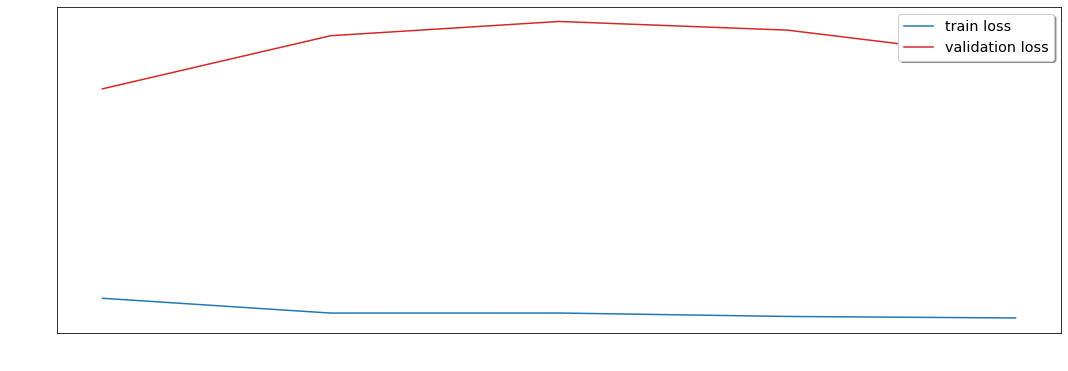

In [22]:
def plot_loss(epoch_array, train_loss_array, valid_loss_array):

    fig = plt.figure(num=1, figsize=(18,6))
    ax = fig.add_subplot(111)

    ax.plot(epoch_array, train_loss_array, color='tab:blue', label='train loss')
    ax.plot(epoch_array, valid_loss_array, color='tab:red', label='validation loss')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.show()

plot_loss(epoch_array, train_loss_array, valid_loss_array)

[9.99854803e-01 1.18568039e-07 9.99992132e-01 ... 9.99999285e-01
 9.99998689e-01 2.69980177e-07]
[1. 0. 1. ... 1. 1. 0.]
accuracy_score:  0.9891681109185442
precision_score:  0.9983561643835617
recall_score:  0.9880694143167028
f1_score:  0.9931861542654675
roc_auc_score:  0.9908019485376617


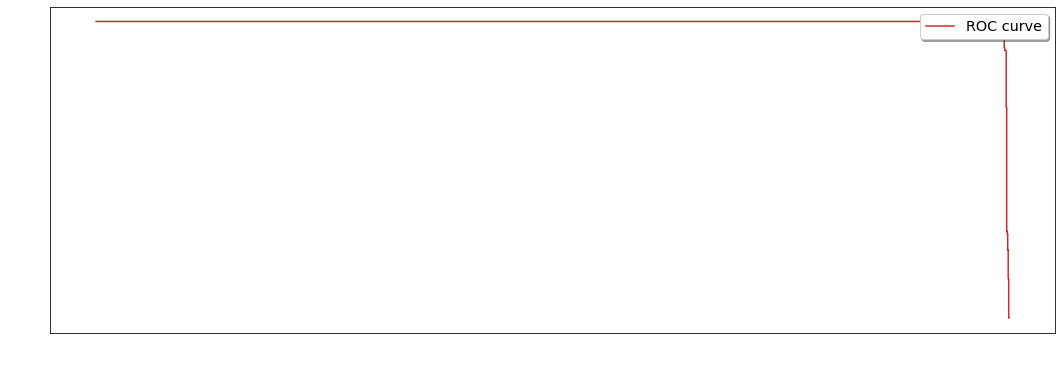

In [23]:
prediction_proba = model_wrapper.predict_proba(test_dataloader)
prediction = model_wrapper.predict(test_dataloader)
y_true = test_dataset.labels.numpy()

print(prediction_proba)
print(prediction)

print('accuracy_score: ', accuracy_score(y_true, prediction))
print('precision_score: ', precision_score(y_true, prediction))
print('recall_score: ', recall_score(y_true, prediction))
print('f1_score: ', f1_score(y_true, prediction))
print('roc_auc_score: ', roc_auc_score(y_true, prediction))

def plot_auc_roc (precision, recall):

    fig = plt.figure(num=1, figsize=(18,6))
    ax = fig.add_subplot(111)
    ax.plot(recall, precision, color='tab:red', label='ROC curve')
    ax.set_xlabel('recall')
    ax.set_ylabel('prcision')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.show()

precision, recall, _ = precision_recall_curve(y_true, prediction_proba)
plot_auc_roc (precision, recall)

In [24]:
model_scripted = torch.jit.script(model_wrapper.model)
model_scripted.save('./saved/model_scripted.pt') 
torch.save(model_wrapper.model, './saved/model.pt')

/opt/conda/lib/python3.6/site-packages/torch/jit/_recursive.py:146: UserWarning: 'downsample' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type UpdatedModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/workspace/db/val/with_mask/medsi/13196.jpg
/workspace/db/val/with_mask/medsi/14579.jpg
/workspace/db/val/with_mask/medsi/15663.jpg
/workspace/db/val/with_mask/sibur/10850_2020-08-12_12-21-13.jpg
/workspace/db/val/with_mask/sibur/910_2020-07-16_07-48-44.jpg
/workspace/db/val/with_mask/medsi/13720.jpg
/workspace/db/val/with_mask/medsi/14678.jpg
/workspace/db/val/with_mask/medsi/15661.jpg
/workspace/db/val/with_mask/sibur/1238_2020-07-16_20-53-45.jpg
/workspace/db/val/with_mask/medsi/13053.jpg
/workspace/db/val/with_mask/medsi/13597.jpg
/workspace/db/val/with_mask/medsi/13373.jpg
/workspace/db/val/with_mask/medsi/14580.jpg
/workspace/db/val/with_mask/sibur/4361_2020-08-10_11-57-14.jpg
/workspace/db/val/with_mask/sibur/147_2020-07-10_19-49-38.jpg
/workspace/db/val/with_mask/py_image_search/132-with-mask.jpg
/workspace/db/val/with_mask/medsi/15187.jpg
/workspace/db/val/with_mask/sibur/783_2020-07-15_20-19-49.jpg
/workspace/db/val/with_mask/sibur/6003_2020-08-06_17-53-08.jpg
/workspace/db/v

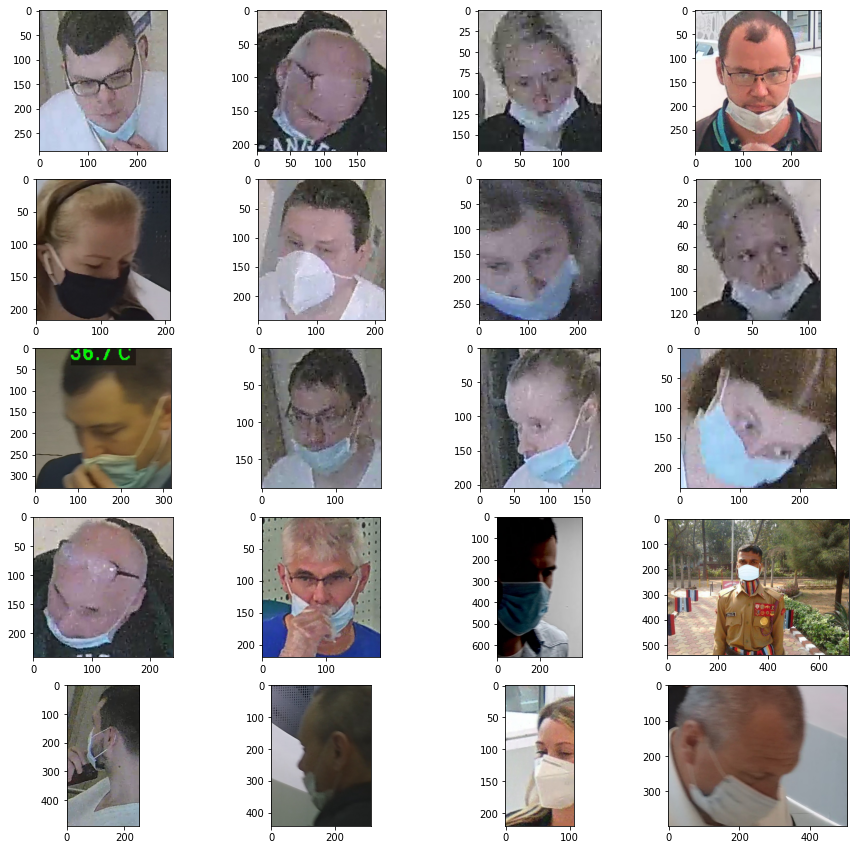

In [25]:
# выведем примеры ошибок (нераспознанные в масках)

male_faults = test_dataset.image_metadata[np.logical_and(y_true.flatten()!=prediction.flatten(), (y_true==1).flatten())]
random_male_faults = np.random.choice(male_faults, size=20, replace=False)
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, 20+1):
    print(random_male_faults[i-1])
    img = Image.open(random_male_faults[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [26]:
# выведем примеры ошибок (нераспознанные без масок)

female_faults = test_dataset.image_metadata[np.logical_and(y_true.flatten()!=prediction.flatten(), (y_true==0).flatten())]
random_female_faults = np.random.choice(female_faults, size=7, replace=False)
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, 20+1):
    img = Image.open(random_female_faults[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
def get_layer_list(module, layer_list=[], duplicates=False):
    
    # метод возвращает список слоев 
    # (если duplicates==False, то повторяющиеся и идентичные по всем параметрам слои не отображаются)  
    
    # итерируем по всем потомкам материнского класса, т.е. модели    
    for item in module.children():
        
        # если этот потомок не является потомком (то есть представляет собой слой),
        # то строка с названием слоя и его параметрами добавляется в лист        
        if list(item.children()) == []: 
            if duplicates: layer_list.append(str(item))
            else:
                # проверка на дубликаты                 
                if str(item) not in layer_list: layer_list.append(str(item))
        
        # если этот потомок имеет своих потомков (то есть явяляется блоком в составе модели),
        # то реккурентно вызываем тот же метод
        else: layer_list = get_layer_list(item, layer_list)
    return layer_list

get_layer_list(pretrained_model, duplicates=True)